#### To overcome from the UNDERFITTING:
- Our main target here is to generate dataset which help us to reduce the false negative.
- When I analyse the dataset, I find that there are some specific data where the model is failing. I try to generate the dataset for those particular cases so we can try to see if model improves or not.

In [6]:
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.utils import shuffle
from src import FeatureGeneration
from src.trainer import train_model
from sklearn.model_selection import train_test_split
from src.utility import print_classifaction_report, save_model
from src.data_augmentation import DataGeneration

In [7]:
nlp = spacy.load('en_core_web_sm')
dataset = pd.read_csv('dataset/supervised_dataset(pruned).csv')

In [8]:
dataset.columns

Index(['document_id', 'line_id', 'text', 'word_bbox', 'label',
       'class_2_target', 'class_3_target'],
      dtype='object')

## Data augmentation via Synthetic data generation

Using Faker, NlpAug & some PMI based data we will create a bunch of templates which resemble the examples in our real data and generate some synthetic examples, which we further use to retrain our models.

In [9]:
# SYNTHETIC DATA TEMPLATES

template_1 = ('{CITY_NAME} {DATE}','partial-addressline')
template_2 = ('{RANDOM_WORDS} {ADDRESS}','partial-addressline')
template_3 = ('{STREET_ADDRESS} {STREET_ADDRESS}','partial-addressline')
template_4 = ('{STREET_ADDRESS} {DATE} {COMPANY_NAME}','partial-addressline')
template_5 = ('{BUILDING_NUMBER} {STREET_NAME} {CAPITAL_WORDS}','partial-addressline')
template_6 = ('{CITY_NAME} {POSTAL_NUMBER}' , 'partial-addressline')
template_7 = ('{BUILDING_NUMBER} {STREET_NAME} {CAPITAL_WORDS} {DATE}','partial-addressline')
template_8 = ('{STREET_ADDRESS} {DATE} {CAPITAL_WORDS} {COMPANY_NAME}', 'partial-addressline')
template_9 = ('{CAPITAL_WORDS} {COMPANY_NAME} {BUILDING_NUMBER} {STREET_NAME}','partial-addressline')

#important features (as i described in previous notebook)
imp_columns = ['avg_token_length', 'more_then_avg', 'alpha_count',
               'stop_word_count', 'punct_count', 'digit_count', 'alpha_num_count',
               'number_of_title_tokens', 'not_alphabet_count', 'number_of_tokens',
               'dolar_count','address_key_words','noun_count','upper_case']

templates = [template_1, template_2, template_4, template_5, template_6, template_7,
             template_3, template_8]

In [10]:
Data = DataGeneration(templates, 500)
augmented_dataset = Data.data

In [12]:
# here are some fake data examples that we just created, 
#these are very similar to the real address lines that we have in our real dataset
augmented_dataset.head()

,text,class_2_target,class_3_target,label,line_id,word_bbox,document_id
0,5605 Gampbel1 Ridges Apt . 587 5605 Camp6el1 R...,addressline,partial-addressline,None,None,None,None
1,641 Adam Harbor 0ate - 12 13 92 Number Henky -...,addressline,partial-addressline,None,None,None,None
2,80913 Cody Green Court DATB OF 2000 / 1b / April,addressline,partial-addressline,None,None,None,None
3,w i t h i n 05010 Nicholas Turnpike\nAmandamou...,addressline,partial-addressline,None,None,None,None
4,3457 Joel Pass 3457 Joel Pass,addressline,partial-addressline,None,None,None,None


In [15]:
augmented_dataset = formating(augmented_dataset)

In [16]:
aug_dataset = pd.concat([dataset, augmented_dataset])

/home/rita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### And now lets get back to models again!

note: I'm using the same test samples from my previous notebook without augmentation so that we can compare the results without  any bias.

In [43]:
### Lets take the original_data as test dataset:
original_data = FeatureGeneration(dataset).transform
original_data = original_data.merge(dataset,  on=['text']).drop_duplicates(subset=['text'])

original_data = shuffle(original_data, random_state=24)
train_data_org, test_data_org = train_test_split(original_data, random_state = 56)
X_train_org, y_train_org = train_data_org[imp_columns], train_data_org['class_2_target']
X_test_org, y_test_org = test_data_org[imp_columns], test_data_org['class_2_target']

In [30]:
feature_dataset_aug = FeatureGeneration(aug_dataset).transform
feature_dataset_aug = feature_dataset_aug.merge(aug_dataset,  on=['text']).drop_duplicates(subset=['text'])

# Data distributions: 

1. plot 1: After augmentation, quite less imbalanced now.
2. plot 2: original data distribution.

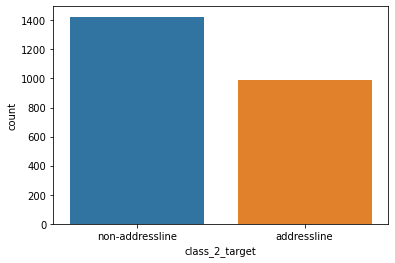

In [31]:
sns.countplot(feature_dataset_aug['class_2_target'],label="Count")
plt.show()

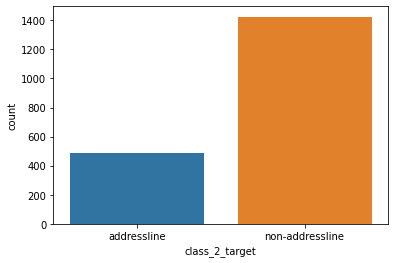

In [33]:
sns.countplot(original_data['class_2_target'],label="Count")
plt.show()

In [35]:
feature_dataset_aug = shuffle(feature_dataset_aug, random_state=24)
train_data, test_data = train_test_split(feature_dataset_aug, random_state = 56)
X_train, y_train = train_data[imp_columns], train_data['class_2_target']
X_test, y_test = test_data[imp_columns], test_data['class_2_target']

In [36]:
rf_model = train_model('random_forest',X_train, y_train)
print_classifaction_report(rf_model, X_test_org, y_test_org)
print('Train dataset\n')
print_classifaction_report(rf_model, X_train, y_train)

[[ 85  51]
 [ 47 296]]
                 precision    recall  f1-score   support

    addressline       0.64      0.62      0.63       136
non-addressline       0.85      0.86      0.86       343

       accuracy                           0.80       479
      macro avg       0.75      0.74      0.75       479
   weighted avg       0.79      0.80      0.79       479

Train dataset

[[552 200]
 [130 927]]
                 precision    recall  f1-score   support

    addressline       0.81      0.73      0.77       752
non-addressline       0.82      0.88      0.85      1057

       accuracy                           0.82      1809
      macro avg       0.82      0.81      0.81      1809
   weighted avg       0.82      0.82      0.82      1809



In [52]:
svc_model = train_model('svm',X_train, y_train)
save_model(svc_model, 'models/svm_aug.pkl')
print_classifaction_report(svc_model, X_test_org, y_test_org)
print('Train dataset\n')
print_classifaction_report(svc_model, X_train, y_train)

[[102  34]
 [ 41 302]]
                 precision    recall  f1-score   support

    addressline       0.71      0.75      0.73       136
non-addressline       0.90      0.88      0.89       343

       accuracy                           0.84       479
      macro avg       0.81      0.82      0.81       479
   weighted avg       0.85      0.84      0.84       479

Train dataset

[[627 125]
 [ 93 964]]
                 precision    recall  f1-score   support

    addressline       0.87      0.83      0.85       752
non-addressline       0.89      0.91      0.90      1057

       accuracy                           0.88      1809
      macro avg       0.88      0.87      0.88      1809
   weighted avg       0.88      0.88      0.88      1809



In [44]:
test_data_org['svm_prediction'] = svc_model.predict(X_test_org[imp_columns])

/home/rita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
false_negative = test_data_org.query(f'svm_prediction == "non-addressline" and class_2_target == "addressline"')
false_positive = test_data_org.query(f'svm_prediction == "addressline" and class_2_target == "non-addressline"')

In [55]:
print(f'False Negative: {len(false_negative)}')
print(f'False Positive: {len(false_positive)}')

False Negative: 34
False Positive: 41


In [48]:
for row in false_negative.sample(n=10).itertuples():
    if row.line_id < 20:
        print(f'text: {row.text}\nline_type: {row.class_3_target}')
        print('-'*100)

text: Course Title : WORK-AT-HEIGHT COURSE FOR NC Learn Union place
line_type: partial-addressline
----------------------------------------------------------------------------------------------------
text: Tax Invoice Email: california@acute.com
line_type: partial-addressline
----------------------------------------------------------------------------------------------------
text: California 127806 PO NO.:
line_type: full-addressline
----------------------------------------------------------------------------------------------------
text: 357103
line_type: partial-addressline
----------------------------------------------------------------------------------------------------
text: Lane California Project Ref: NFI/15/10135 ...
line_type: partial-addressline
----------------------------------------------------------------------------------------------------
text: Toronto, Road
line_type: partial-addressline
---------------------------------------------------------------------------------

In [50]:
for row in false_positive.sample(n=10).itertuples():
    if row.line_id < 20:
        print(f'text: {row.text}\nline_type: {row.class_3_target}')
        print('-'*100)

text: Attn: RoggetrTarren HP: 9025 6161 Fax: 4309 4865 Tel: 4197 4475
line_type: non-addressline
----------------------------------------------------------------------------------------------------
text: Company Registration No. 1003380910
line_type: non-addressline
----------------------------------------------------------------------------------------------------
text: Mr. Kevin F Meredith Freight Operator RS SGD 2,899.00
line_type: non-addressline
----------------------------------------------------------------------------------------------------
text: MX-DE27 STAND/550X3 SHEET PAPER DRAWER i PC SGD 0.00 0.00 0.00 0.00
line_type: non-addressline
----------------------------------------------------------------------------------------------------
text: GST REG NO: 201022750W 27500
line_type: non-addressline
----------------------------------------------------------------------------------------------------
text: Hong He General Contractor. 15,170.00 Spuy
line_type: non-addressline
---

### Observation:
In short, here is summary of all the different experiments we did so far.
![](score.png)

1. As you can see from the above image, data augmentation has definetly improved our overall results, as highlighted above.
But, since we are working with very less data points here, ideally it would make sense for us to explore this further with maybe a bit more examples.
2. There are multiple other ideas that we could further explore/experiment and see. for instance since we  have a huge set of non-addresslines. we can use that to train a one class model to tag non-addresslines, and whereever the model does not tag, could essentially be our potential candidates for addresslines
3. Also, address similarity model is something we can use, to assign some sort of score to the detected lines to further improve our results.